In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import pandas as pd

In [2]:
datagfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#GFP_corrected")
datarfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#RFP")

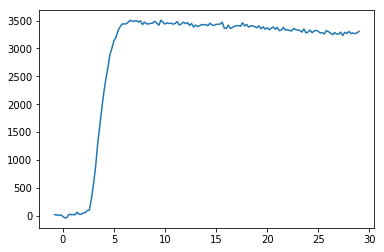

In [3]:
plt.plot(datagfp["Time [h]"],datagfp["#10^3 molecules eGFP crosstalk corrected.2"])

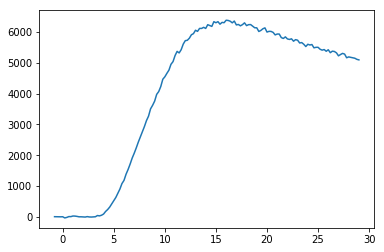

In [4]:
t = datarfp["Time [h]"]
tt = datarfp["Time [h]"]
data = datarfp["#10^3 molecules CayRFP.2"]
noise = np.sqrt(np.abs(data))
plt.plot(t,data)

In [5]:
def DE(t, t0, m, k, beta, delta, offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset


In [13]:
m_ktl_0 = 2e4

tr_0 = 4.5
kmr_0 = 0.3
betr_0 = 0.0421
deltr_0 = 0.03
offr_0 = 0

DE_model = lm.Model(DE)
pars = DE_model.make_params()
pars['t0'].set(value=tr_0,vary=True)
pars['m'].set(value=m_ktl_0,vary=True)
pars['k'].set(value=kmr_0,vary=False)
pars['beta'].set(value=betr_0,vary=False)
pars['delta'].set(value=deltr_0,vary=True)
pars['offset'].set(value=offr_0,vary=True)

out = DE_model.fit(data, pars, t=tt, weights=1/noise)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(DE)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 150
    # variables        = 4
    chi-square         = 780.974974
    reduced chi-square = 5.34914366
    Akaike info crit   = 255.486172
    Bayesian info crit = 267.528713
[[Variables]]
    t0:      3.58069143 +/- 0.02829201 (0.79%) (init = 4.5)
    m:       2352.13642 +/- 33.5300421 (1.43%) (init = 20000)
    k:       0.3 (fixed)
    beta:    0.0421 (fixed)
    delta:   0.20469593 +/- 0.00342056 (1.67%) (init = 0.03)
    offset:  0.87442986 +/- 0.68056390 (77.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(m, delta)  =  0.977
    C(t0, m)     =  0.735
    C(t0, delta) =  0.714



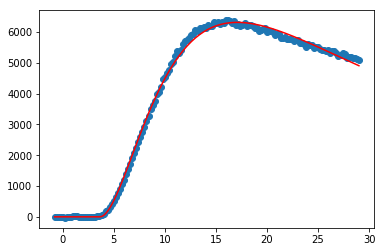

In [7]:
plt.plot(t,data,"o")
plt.plot(t, out.best_fit, 'r-')

In [8]:
import pymc as pm

In [9]:
m_ktl_0 = 2e4

tr_0 = 4.5

kmr_0 = 0.3
kmr_sigma = 0.08

betr_0 = 0.0421
betr_sigma = 0.013

deltr_0 = 0.03
offr_0 = 0

t0 = pm.Uniform('t0',lower=0,upper=10)
m = pm.Uniform('m',lower = 0, upper =5*m_ktl_0)
k = pm.Normal('k',mu=kmr_0,tau=1/kmr_sigma)
beta = pm.Normal('beta',mu=betr_0,tau=1/betr_sigma)
delta = pm.Uniform('delta',lower=0,upper=1.0)
offset = pm.Uniform('offset',lower=0,upper=5.0)

@pm.deterministic
def DE_pm(t=tt, t0=t0, m=m, k=k, beta=beta, delta=delta, offset=offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset

obs = pm.Normal('obs', mu=DE_pm, tau=1/noise**2, observed=True,
                value=data)

 [-----------------100%-----------------] 130000 of 130000 complete in 2524.1 sec

(array([    88.,    964.,   4580.,  14627.,  26285.,  29432.,  17413.,
          5503.,   1006.,    102.]),
 array([ 3.56949206,  3.58316282,  3.59683359,  3.61050435,  3.62417511,
         3.63784588,  3.65151664,  3.6651874 ,  3.67885817,  3.69252893,
         3.70619969]),
 <a list of 10 Patch objects>)

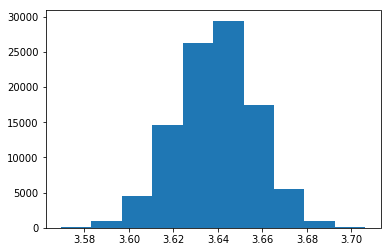

In [10]:
SAMPLES = 100000
BURN = 30000

model = pm.Model([t0, m, k, beta, delta,offset,obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

plt.hist(mcmc.trace('t0')[:])

Plotting delta
Plotting offset
Plotting t0
Plotting m
Plotting k
Plotting beta


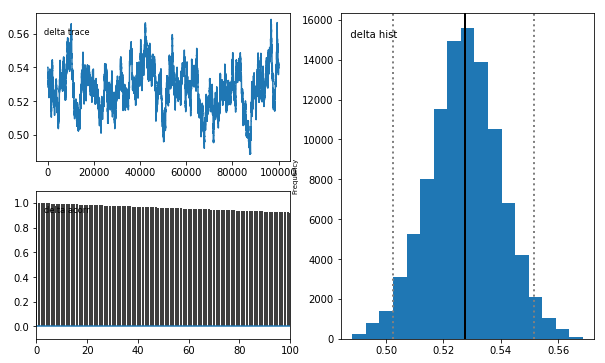

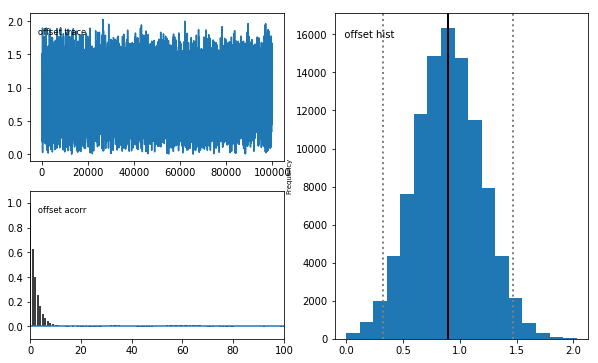

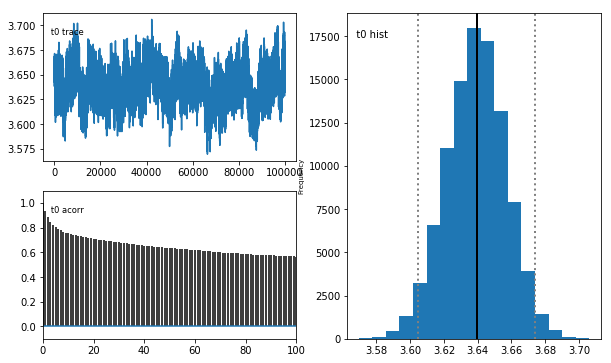

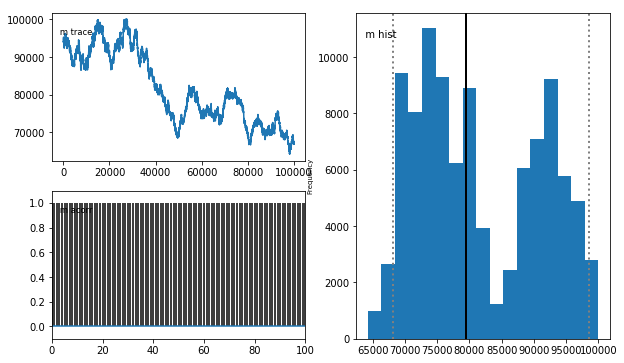

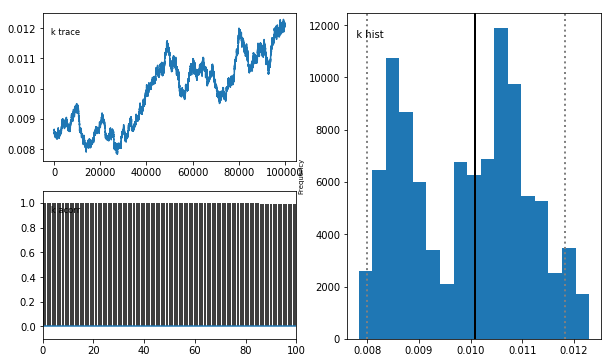

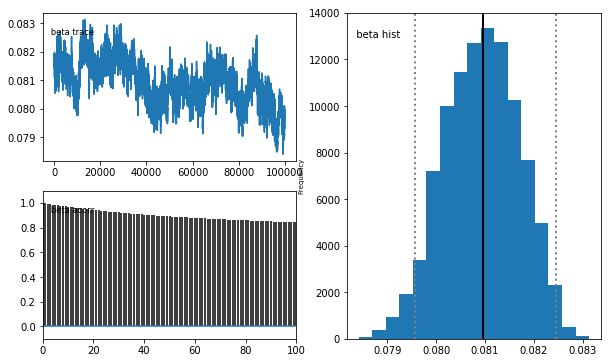

In [11]:
pm.Matplot.plot(mcmc)

In [12]:
mcmc.summary()


delta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.527            0.012            0.001            [ 0.502  0.552]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.503            0.519           0.528          0.536         0.552
	

offset:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.897            0.291            0.002            [ 0.327  1.467]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.327            0.7             0.895          1.094         1.468
	

t0:
 
	Mean             SD               MC Error        95% HPD interval
	-----------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
